In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook allows individual runs for each dataset (parts 1 and 2) as well as the computation of the water budget for given datasets. 

## Colors definition

We load the climate colormap from the Koppen-Geiger classification. The variable is the opacity (0.8 by default). We also load a dictionary `climate_color_dict` that associates the color to each climate label. Color maps are either defined for all 31 zones (`approximate=False`) or for 5 largest zones (`approximate=True`).

In [2]:
approximate=True
if approximate:
    cmap_climate=ListedColormap(np.loadtxt("../datasets/other/koppen_geiger_color_array_approx.csv"))
else:
    cmap_climate=ListedColormap(np.loadtxt("../datasets/other/koppen_geiger_color_array.csv"))

# 1. Load data

Common time index where all variables are available

In [3]:
time_idx=pd.date_range(start='01-2003',end='1-2017',freq='SM')[::2]

Load the spatial grid where variables are available (`spatial_grid`).

`hydro_grid` is a DataFrame with each row representing a cell grid and each column is a month

`time_hydro` is the set of months when the current variable is known

- For precipitations (`P`) choose among : 'CPC', 'TRMM'

- For evapotranspiration (`ET`) choose among : 'GLDAS', 'SEB'

- For runoff (`R`) choose among 'GLDAS', 'MERRA'

- For water storage (`TWS`) choose among 'GRACE_JPL'

In [4]:
hydro_var_name='ET'
data="SEB"
(spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,time_idx, fill_nan=True)

<div class="alert alert-block alert-info">
<b>Fun fact to look at:</b> With ET from GLDAS, we sometimes have negative values (for example December 2003.
</div>

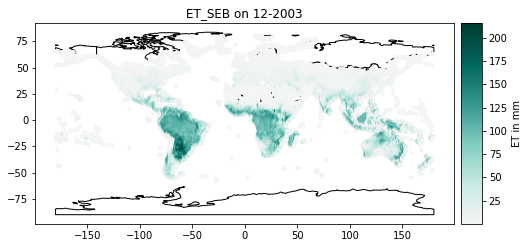

In [5]:
month='12'
year='2003'

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

norm,cmap=define_cmap(hydro_var_name,hydro_grid,year,month)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='black')
hydro_grid.plot(ax=ax,marker='.',column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
            cmap=cmap,norm=norm)
ax.set_title('{}_{} on {}-{}'.format(hydro_var_name,data,month,year))
plt.show()

Load basins data : 
- `RASTAREA` is the basin area in km^2
- `MAIN_CLIMATE` is the Koppen-Geiger climate zone covering the largest part of the basin
- `CLIMATE_AREA_%` is the area percentage covered by the main climate
- `COLOR` is the official color associated to the climate area
- `NB_RUNOFF` is the number of stations inside the basin in operation at least 1 year between 2003 and 2017

In [6]:
basins=load_basins_data(approximate)
basins

,RASTAREA,LATITUDE,MAIN_CLIMATE,CLIMATE_AREA_%,COLOR,NB_RUNOFF,geometry
NAME,,,,,,,
KHATANGA,265580.70,69.00,D,91.129714,#ff6eff,0,"POLYGON ((107.98472 70.60880, 107.99635 70.602..."
COLVILLE RIVER,54793.19,69.00,E,70.030254,#6395ff,1,"POLYGON ((-151.63553 68.05583, -151.56200 68.0..."
ODER RIVER,107297.80,51.75,C,94.763680,#007800,53,"POLYGON ((17.77023 53.33484, 17.75817 53.27876..."
ELBE RIVER,134036.70,51.00,C,96.768446,#007800,69,"POLYGON ((15.71059 50.73571, 15.80232 50.74939..."
TRENT,5591.48,53.00,C,100.000000,#007800,8,"POLYGON ((-1.04140 52.50355, -1.07763 52.46482..."
...,...,...,...,...,...,...,...
URAL,194095.00,52.00,D,97.769008,#ff6eff,0,"POLYGON ((59.45863 54.73093, 59.45405 54.71379..."
WISLA,186147.40,51.50,D,58.274787,#ff6eff,36,"POLYGON ((23.27742 53.82209, 23.28833 53.78495..."
DON,378180.40,50.25,D,100.000000,#ff6eff,1,"POLYGON ((44.20445 47.83303, 44.16977 47.78534..."


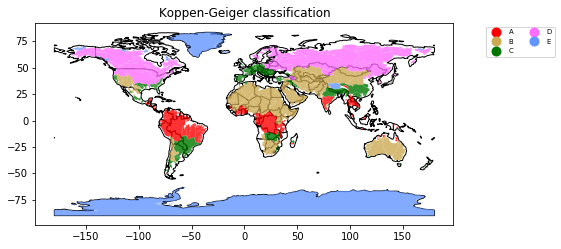

In [7]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.plot(ax=ax, column='MAIN_CLIMATE', categorical=True,
             legend=True, cmap=cmap_climate,
                 legend_kwds={'bbox_to_anchor':(1.25,1.0),'ncol':2,'fontsize':'x-small'})
ax.set(title='Koppen-Geiger classification')
fig.tight_layout()
plt.show()

# 2. Hydrological variables in a given basin

## Basin selection

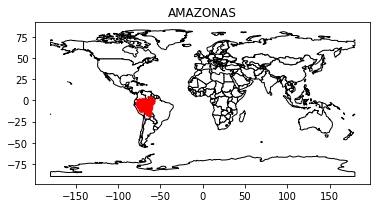

In [8]:
basin_name='AMAZONAS'

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_name],'geometry'].plot(ax=ax, color=basins.loc[basin_name,'COLOR'])
plt.title(basin_name)
plt.show()

To find the grid coordinates loacted inside a given basin, we rely on R-trees (__[reference](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html)__) in the function `find_coordinates_inside_basin`. The method is the following : 

1. we compare the bounds of the Polygon into the spatial index of the Points. This gives us point candidates that are likely to be within the Polygon (at this stage based on the MBR of the points that is stored inside the R-tree). 

1. we go through the candidate points and make a normal spatial intersection query that gives us the accurate results

In [9]:
my_basin=basins.loc[[basin_name],'geometry']
final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)

In [10]:
hydro_basin=hydro_grid.loc[final_selection.index]

## Missing values

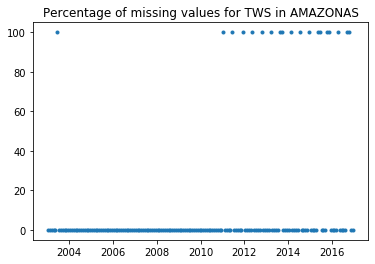

In [11]:
plt.figure()
plt.plot(time_idx,100*hydro_basin.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_idx]].isna().sum()/final_selection.shape[0],'.')
plt.title("Percentage of missing values for {} in {}".format(hydro_var_name,basin_name))
plt.show()

If needed, we reconstruct missing values with interpolation (cubic by default)

In [12]:
hydro_basin=my_fillna(hydro_basin,hydro_var_name,time_idx)

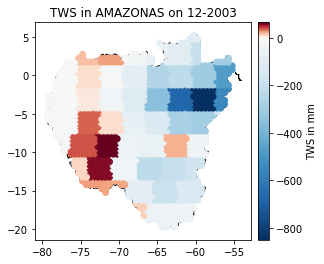

In [13]:
norm,cmap=define_cmap(hydro_var_name,hydro_basin,year,month)

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
my_basin.plot(ax=ax, color='white', edgecolor='black')
hydro_basin.plot(ax=ax,column='{} {}-{}-15'.format(hydro_var_name,year,month),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
            cmap=cmap,norm=norm)
ax.set_title('{} in {} on {}-{}'.format(hydro_var_name,basin_name,month,year))
plt.show()

## Spatial averaging

In [14]:
hydro_mean_basin, hydro_mean_basin_filter=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_idx,data)

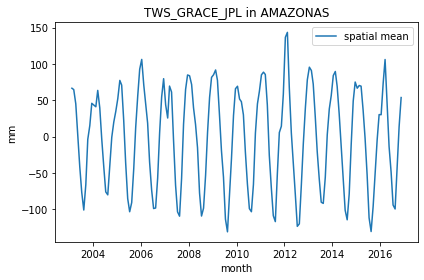

In [15]:
plt.figure()
if hydro_var_name=='TWS': # filtered and unfiltered variables are the same for water storage CHANGES
    plt.plot(time_idx[1:-1],hydro_mean_basin,label='spatial mean')
else:
    plt.plot(time_idx,hydro_mean_basin,'--',label='spatial mean')
    plt.plot(time_idx[1:-1],hydro_mean_basin_filter,label='spatial mean filtered')
plt.legend()
plt.xlabel("month")
plt.ylabel("mm")
plt.title("{}_{} in {}".format(hydro_var_name,data,basin_name))
plt.tight_layout()
plt.show()

# 3. Water budget

Load datasets

In [16]:
data_P="TRMM"
(spatial_grid_P,P_grid,time_P)=load_hydro_data('P',data_P,time_idx)

data_R="GLDAS"
(spatial_grid_R,R_grid,time_R)=load_hydro_data('R',data_R,time_idx)

data_ET="GLDAS"
(spatial_grid_ET,ET_grid,time_ET)=load_hydro_data('ET',data_ET,time_idx)

data_TWS="GRACE_JPL"
(spatial_grid_TWS,TWS_grid,time_TWS)=load_hydro_data('TWS',data_TWS,time_idx)

Show data availability for each dataset

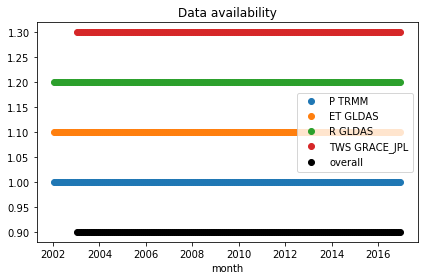

In [17]:
plt.figure()
plt.plot(time_P.values,[1]*time_P.shape[0],'o',label='P {}'.format(data_P))
plt.plot(time_ET.values,[1.1]*time_ET.shape[0],'o',label='ET {}'.format(data_ET))
plt.plot(time_R.values,[1.2]*time_R.shape[0],'o',label='R {}'.format(data_R))
plt.plot(time_TWS.values,[1.3]*time_TWS.shape[0],'o',label='TWS {}'.format(data_TWS))
plt.plot(time_idx.values,[0.9]*time_idx.shape[0],'ko',label='overall')
plt.legend()
plt.title("Data availability")
plt.xlabel("month")
plt.tight_layout()
plt.show()

Create dictionnaries to easily store variables and loop over them

In [18]:
spatial_grid={'P':spatial_grid_P,'R':spatial_grid_R,'ET':spatial_grid_ET,'TWS':spatial_grid_TWS}
hydro_grid={'P':P_grid,'R':R_grid,'ET':ET_grid,'TWS':TWS_grid}
hydro_filter=dict()

Select one particular basin

In [19]:
basin_name='AMAZONAS'
my_basin=basins.loc[[basin_name],'geometry']

Compute hydrological variables over the basin. Note : `final_selection` needs to be defined for each variable beacuase datasets don't necessarily have the same grid.

In [20]:
for hydro_var_name,data in zip(['P','ET','R','TWS'],[data_P,data_ET,data_R,data_TWS]):
    final_selection=find_coordinates_inside_basin(my_basin,spatial_grid[hydro_var_name],basins)
    hydro_basin=hydro_grid[hydro_var_name].loc[final_selection.index]
    hydro_basin=my_fillna(hydro_basin,hydro_var_name,time_idx)
    hydro_filter[hydro_var_name]=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,time_idx,data)[1]

In [21]:
P_filter=hydro_filter['P']
R_filter=hydro_filter['R']
ET_filter=hydro_filter['ET']
TWSC_filter=hydro_filter['TWS']

The net accumulation is defined as $A(t)=P(t) - ET(t) - R(t)$. It satisfies $\dfrac{dS}{dt} = A(t)$.

In [22]:
A_filter=P_filter-ET_filter-R_filter

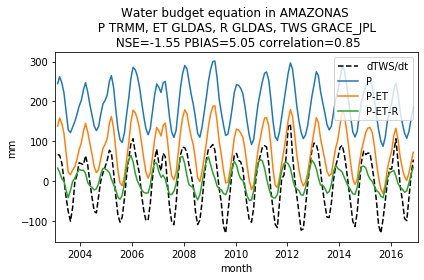

In [23]:
# performance metrics
corr=A_filter.corr(TWSC_filter)
PBIAS=percentage_bias(A_filter,TWSC_filter)
NSE=compute_NSE(A_filter,TWSC_filter)

plt.figure()
plt.plot(TWSC_filter,'k--',label='dTWS/dt')
plt.plot(P_filter,label='P')
plt.plot(P_filter-ET_filter,label='P-ET')
plt.plot(A_filter,label='P-ET-R')
plt.legend()
plt.title("Water budget equation in {} \n P {}, ET {}, R {}, TWS {} \n NSE={:.2f} PBIAS={:.2f} correlation={:.2f}".format(basin_name,
                        data_P,data_ET,data_R,data_TWS,NSE,PBIAS,corr))
plt.xlabel("month")
plt.ylabel("mm")
plt.xlim([date(2003,1,15),date(2017,1,15)])
plt.tight_layout()
plt.show()